In [2]:
%matplotlib inline
import os
import math
import random
import pprint
import numpy as np
import pandas as pd
import sklearn.metrics as metrics 
import matplotlib.pyplot as plt

In [3]:
# for time being - we will use the famous.. Iris dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
print('URL:', url)

col_names = ['sepal_length', 'sepal_width','petal_length','petal_width','species']
df = pd.read_csv(url, header=None, names=col_names, encoding='utf-8')

# we have 'Iris-setosa', 'Iris-versicolor', and 'Iris-virginica' 
# species; we will convert it to numeric as labels
print('Species: ', df['species'].unique())

df.loc[(df['species'] == 'Iris-setosa', 'species')] = 0
df.loc[(df['species'] == 'Iris-versicolor', 'species')] = 1
df.loc[(df['species'] == 'Iris-virginica', 'species')] = 2

df = df.rename(columns={"species": "label"})
#df.head()

URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
Species:  ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [4]:
# split our dataset to train and test randomly
def train_test_split(X, y, test_size = 0.3):
    if isinstance(test_size, float):
        test_size = round(test_size * len(X))

    indices = [*range(len(X))]
    test_indices = random.sample(population=indices, k=test_size)
    
    X_test = X[test_indices].astype('float')
    y_test = y[test_indices].astype('int')
    
    X_train = np.delete(X, test_indices, axis=0).astype('float')
    y_train = np.delete(y, test_indices, axis = None).astype('int')
    
    return X_train, X_test, y_train, y_test

In [5]:
X = df.iloc[:,:4].values
y = df.iloc[:,4].values

random.seed(0) # random seed to reproduce our results
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3)

In [6]:
class DecisionTreeClassifier(object):
    def __init__(self, max_depth = 5):
        self.depth = 0
        self.max_depth = max_depth # define the node levels
        self.infogain = dict()
    
    def fit(self, x, y, root_node={}, depth=0):    
        # checking if all our labels is the same otherwise we are done here
        all_same = all(i == y[0] for i in y)
    
        if all_same:
            return {'class':y[0]}
        elif len(y) == 0:
            return None
        elif root_node is None: 
            return None
        elif depth >= self.max_depth:
            print('Fucking Bitch')
            return None
       
        if len(self.infogain) == 0:
            # compute our information gain
            self.infogain = self.getInfoGain(y)
    
        # split by the lowest entropy
        att, condition, entropy, infogain, gainratio = self.splitAttribute(x, y)     
        #print(entropy)
        root_node = {'attribute': col_names[att], 'index_att':att,
                     'condition':condition,'class': np.round(np.mean(y))} # for multiclass, take the average

        # using recursion, we wil run the fit function on our left and right node..
        y_left = y[x[:, att] < condition]
        x_left = x[x[:, att] < condition]

        y_right = y[x[:, att] >= condition]
        x_right = x[x[:, att] >= condition]

        root_node['left_node'] = self.fit(x_left, y_left, {}, depth+1)
        root_node['right_node'] = self.fit(x_right, y_right, {}, depth+1)

        self.depth += 1    # increase the depth of our tree
        self.root_node = root_node  # store our tree
        return root_node
    
    
    def getInfoGain(self, y):
        num = len(y)
        infogain = dict()
        for label in set(y):
            positive = sum(y==label) # true
            negative = sum(y!=label) # false
            ent = self.entropyCalc(positive, negative) 
            infogain[label] = ent
        return infogain
    
    def splitAttribute(self, x, y):
        att = None 
        condition = None
        infogain = self.infogain
        min_entropy = 1
        max_gain = 0 
        max_infogain= 0
        for i, c in enumerate(x.T):
            # loop per attribute to find the best feature to split
            ent, condition_test = self.getMinimumEntropy(c, y)
            if ent == 0:# return if entropy is zero
                return i, condition_test, ent, max_infogain, max_gain
            
            
            # find the minimum_entropy
            if ent <= min_entropy:
                overall_infogain = []
                for label in set(y):
                        overall_infogain.append(infogain[label] - ent)
                max_infogain = max(overall_infogain)
                # retrieve maximum information gain        
                split_info = self.getSplitInfo(c, y, i, condition_test)    
                gain = self.getGainRatio(max_infogain, split_info)
                if gain > max_gain:
                    att = i
                    min_entropy = ent
                    max_infogain = max_infogain
                    max_gain = gain
                    condition = condition_test
                
                
        return att, condition, min_entropy, max_infogain, max_gain
    
    def getSplitInfo(self, x, y, att, condition): #C4.5
        if len(y) == 0:
            return None
        
        y_num = len(y)    
        y_left = len(y[x < condition])
        y_right = len(y[x >= condition])

        if y_left == 0:
            left_split = 0
        else:    
            left_split = -(y_left/y_num)* math.log(y_left/y_num, 2)
        if y_left == 0:
            right_split = 0
        else:       
            right_split = -(y_right/y_num)* math.log(y_right/y_num, 2)
        
        return left_split + right_split
        
        
    def getGainRatio(self, max_infogain, split_info):
        if split_info == 0: 
            return 0
        return max_infogain/split_info
    
    
    def getMinimumEntropy(self, att, y):
        n = len(y)
        minimum_entr = 1
        # loop trought unique value and find the lowest entrophy
        for value in set(att):
            y_pred = att < value
            # retrieve our entropy on each attributes
            entr = self.getEntropy(y_pred, y)
            if entr <= minimum_entr:
                condition = value
                minimum_entr = entr
        return minimum_entr, condition
    
    def getEntropy(self, y_pred, y): 
        # this will get me the entropy on the possible split
        num = len(y)
        # calculate the entropy left_node and right_node entropy
        entrophy_positive, num_positive = self.entropyNode(y[y_pred])
        entrophy, num_negative = self.entropyNode(y[~y_pred]) 
        # overall entropy
        overall_entropy = num_positive/num * entrophy_positive + num_negative/num * entrophy
        
        return overall_entropy
    
    def entropyNode(self, labels): 
        total_entropy = 0
        num = len(labels)
        classes = set(labels)
        #compute each entrophy; example from the slides:
        #     E(P_Usage) = 6/15 I(1,5) + 6/15 I(5,1) + 3/15 I(3,0)
        for label in classes:   
            positive = sum(labels==label) # true
            negative = sum(labels!=label) # false
            ent = positive/num * self.entropyCalc(positive, negative) 
            total_entropy += ent
        return total_entropy, num
    
    def entropyCalc(self, positive, negative):
        # if one contains all the same classes, entropy will return 0
        if positive== 0 or negative == 0: 
            return 0
        num = positive + negative

        # calculate the info gain with entropy 
        positive_side = -(positive/num) * math.log(positive/num, 2)
        negative_side = -(negative/num) * math.log(negative/num, 2)
    
        return positive_side + negative_side
                                      
    def predict(self, x):
        tree = self.root_node
        
        result = np.array([0]*len(x))
        for i, c in enumerate(x):
            result[i] = self.parseTree(c)
        return result
    
    def parseTree(self, row):
        tree = self.root_node
        #pprint.pprint(tree)
        # simply traverse down the tree on each attribute
        while tree.get('condition', {}):
            if row[tree['index_att']] < tree['condition']:
                tree = tree['left_node']
            else:
                tree = tree['right_node']
        else:
            return tree.get('class')

In [7]:
dt = DecisionTreeClassifier(max_depth=5)
result = dt.fit(X_train, y_train)
pprint.pprint(result)
y_pred = dt.predict(X_test)

{'attribute': 'petal_length',
 'class': 1.0,
 'condition': 3.3,
 'index_att': 2,
 'left_node': {'class': 0},
 'right_node': {'attribute': 'petal_width',
                'class': 2.0,
                'condition': 1.7,
                'index_att': 3,
                'left_node': {'attribute': 'petal_length',
                              'class': 1.0,
                              'condition': 5.0,
                              'index_att': 2,
                              'left_node': {'class': 1},
                              'right_node': {'attribute': 'petal_width',
                                             'class': 2.0,
                                             'condition': 1.6,
                                             'index_att': 3,
                                             'left_node': {'class': 2},
                                             'right_node': {'class': 1}}},
                'right_node': {'class': 2}}}


In [8]:
target_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica' ]
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

print('Accuracy score: ', (y_test == y_pred).sum() / len(y_test))
print('Misclassified examples: %d' % (y_test != y_pred).sum())

                 precision    recall  f1-score   support

    Iris-setosa       0.93      1.00      0.97        14
Iris-versicolor       0.93      0.82      0.87        17
 Iris-virginica       0.87      0.93      0.90        14

       accuracy                           0.91        45
      macro avg       0.91      0.92      0.91        45
   weighted avg       0.91      0.91      0.91        45

Accuracy score:  0.9111111111111111
Misclassified examples: 4


In [9]:
class NaiveBayesClassifier(object):
    def __init__(self,unique_classes = None):
        self.classes=unique_classes 

    def combineData(self, X, y):
        # combmine our attributes and labels
        dataset = []
        for i in range(len(X)):
            dataset.append(X[i].tolist()+[y[i]])
        return dataset
    
    def fit(self, X, y):
        if len(X)==0 or len(y) == 0:
            return None
        elif X is None or y is None:
            return 0
        else:
            datasets = self.combineData(X, y)
            
            # training phase which returns the prior probability on each labels
            self.model = self.infoPerClass(datasets)
            return self.model
        
    def infoCalc(self, datasets):
        info = []
        # calculate the mean, standard deviation and count for each dataset
        for col in zip(*datasets):
            info.append([np.mean(col), np.std(col), len(col)])
        info.remove(info[-1])
        return info

    def infoPerClass(self,datasets):
        # collect all dataset on each labels
        label_sets = self.datasetPerClass(datasets)
        
        info = dict() # info of each class
        for label, data in label_sets.items():
            info[label] = self.infoCalc(data)
        return info
    
    def datasetPerClass(self, datasets):
        # collect all dataset on each labels
        label_sets = dict() # used dictionary to return
        for i, c in enumerate(datasets):
            label = c[-1] # last column is our labels
            if (label not in label_sets):
                label_sets[label] = list() # create a list in the dictionary
            label_sets[label].append(c)
        return label_sets

    def calcProb(self, x, mean, stdev):
        exponent = math.exp(-((x-mean)**2 / (2 * stdev**2 )))
        return (1 / (math.sqrt(2 * math.pi) * stdev)) * exponent

    def calcClassProb(self, row):
        summaries = self.model
        
        totals = []
        for label in summaries:
            totals.append(summaries[label][0][2])
        total_rows = sum(totals)
        
        probabilities = dict()
        for class_value, class_summaries in summaries.items():
            probabilities[class_value] = summaries[class_value][0][2]/float(total_rows)
            
            # calculate the probabilities on each testing set
            for i in range(len(class_summaries)):
                mean, stdev, _ = class_summaries[i]
                probabilities[class_value] *= self.calcProb(row[i], mean, stdev)
        return probabilities

    def predict(self, X_test):
        row = X_test.tolist()
        label=[]
        # iterate our testing set and get the likehood class
        for i, c in enumerate(row):
            probabilities = self.calcClassProb(c)
            best_label, best_prob = None, -1
            for class_value, probability in probabilities.items():
                # list all probabilities each class and select the highest one
                if best_label is None or probability > best_prob:
                    best_prob = probability
                    best_label = class_value
            label.append(best_label)
        return label

In [10]:
nb = NaiveBayesClassifier()
result = nb.fit(X_train,y_train)
y_pred = nb.predict(X_test)

In [11]:
y_pred = np.asarray(y_pred)

target_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica' ]
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

print('Accuracy score: ', (y_test == y_pred).sum() / len(y_test))
print('Misclassified examples: %d' % (y_test != y_pred).sum())

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        14
Iris-versicolor       1.00      0.82      0.90        17
 Iris-virginica       0.82      1.00      0.90        14

       accuracy                           0.93        45
      macro avg       0.94      0.94      0.94        45
   weighted avg       0.95      0.93      0.93        45

Accuracy score:  0.9333333333333333
Misclassified examples: 3


In [12]:
def combineData(X, y):
    dataset = []
    for i in range(len(X)):
        dataset.append(X[i].tolist()+[y[i]])
    return dataset

def crossValidationFold(dataset, folds=3):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / folds)
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            index = random.randrange(len(dataset_copy))
            #index = range(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

# Calculate accuracy percentage
def accuracyMetric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0
 
# Evaluate an algorithm using a cross validation split
def crossValidation(X, y, algorithm, n_folds, **kwargs):
    dataset = combineData(X,y)
    folds = crossValidationFold(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy.remove(row_copy[-1])
       
        y_pred = algorithm(train_set, test_set, **kwargs)
        y_test = [row[-1] for row in fold]
        accuracy = accuracyMetric(y_test, y_pred)
        scores.append(accuracy)
    return scores


def naiveBayes(train_set, X_test):
    y_train = [row[-1] for row in train_set]
    X_train = [row[:-1] for row in train_set]
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    
    nb = NaiveBayesClassifier()
    result = nb.fit(X_train,y_train)
    y_pred = nb.predict(X_test)

    return y_pred

def decisionTree(train_set, X_test, max_depth=5):
    y_train = [row[-1] for row in train_set]
    X_train = [row[:-1] for row in train_set]
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
   
    dt = DecisionTreeClassifier(max_depth)
    result = dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test) 
    return y_pred

In [13]:
names = []
result = []

random.seed(0)
dt_scores =  crossValidation(X, y, decisionTree, n_folds = 10, max_depth = 8)
print('Scores: %s' % dt_scores)
print('Mean Accuracy: %.3f%%' % (sum(dt_scores)/float(len(dt_scores))))
result.append(dt_scores)
names.append('Decision Tree: C4.5 Algorithm')

Scores: [80.0, 86.66666666666667, 93.33333333333333, 100.0, 86.66666666666667, 100.0, 100.0, 93.33333333333333, 100.0, 100.0]
Mean Accuracy: 94.000%


In [14]:
random.seed(0)
nb_scores =  crossValidation(X, y, naiveBayes, n_folds = 10)
print('Scores: %s' % nb_scores)
print('Mean Accuracy: %.3f%%' % (sum(nb_scores)/float(len(nb_scores))))
result.append(nb_scores)
names.append('Naive Bayes')

Scores: [86.66666666666667, 93.33333333333333, 93.33333333333333, 100.0, 86.66666666666667, 100.0, 100.0, 100.0, 93.33333333333333, 100.0]
Mean Accuracy: 95.333%


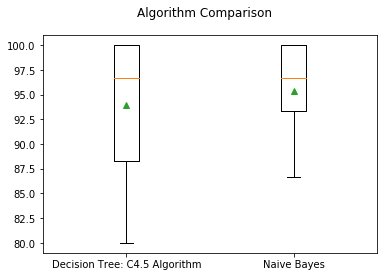

In [15]:
# Boxplot Graph
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(result, showmeans=True)
ax.set_xticklabels(names)
plt.show()

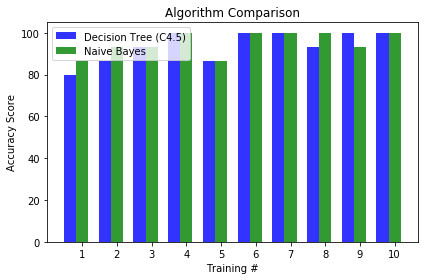

In [16]:
# Bar Graph
n_groups = 10

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, dt_scores, bar_width,
                 alpha=opacity,color='b',label='Decision Tree (C4.5)')

rects2 = plt.bar(index + bar_width, nb_scores, bar_width,
                 alpha=opacity,color='g',label='Naive Bayes')

plt.xlabel('Training #')
plt.ylabel('Accuracy Score')
plt.title('Algorithm Comparison')
plt.xticks(index + bar_width, ('1', '2', '3', '4', '5',
                               '6', '7', '8', '9', '10'))
plt.legend()

plt.tight_layout()
plt.show()
